In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. 指標計算関数 --- 

def compute_aa_and_aia(acc_matrix: list[list[float]]):
    """AA_kとAIA_kを計算"""
    AA_list, AIA_list = [], []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        AA_k = sum(current_accs)/len(current_accs) if current_accs else 0
        AA_list.append(AA_k)
        AIA_k = sum(AA_list)/len(AA_list) if AA_list else 0
        AIA_list.append(AIA_k)
    return AA_list, AIA_list

def compute_fm(acc_matrix: list[list[float]]):
    """忘却量 FM_kを計算"""
    fm_list = [0.0]
    num_tasks = len(acc_matrix)
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            past_accs = [acc_matrix[l][j] for l in range(j, k) if j < len(acc_matrix[l])]
            max_past_acc = max(past_accs) if past_accs else 0
            current_acc = acc_matrix[k][j] if j < len(acc_matrix[k]) else 0
            forgetting_sum += (max_past_acc - current_acc)
        fm_list.append(forgetting_sum/k if k>0 else 0)
    return fm_list

def compute_im(acc_matrix: list[list[float]], joint_accs: list[float]):
    """非妥協性 IM_kを計算"""
    im_list = []
    num_tasks = len(acc_matrix)
    for k in range(num_tasks):
        if k < len(joint_accs) and k < len(acc_matrix[k]):
            im_list.append(joint_accs[k] - acc_matrix[k][k])
        else:
            im_list.append(np.nan)
    return im_list

# --- 2. CSV読み込み & 指標計算 ---

csv_dir = "/work/csv/uci-har/cil-er/"
joint_csv_path = "/work/csv/uci-har/cil-joint/ltc_ncps.csv"

mem_values = [0, 100, 250, 500, 1500, 3000]
bs_values = [32, 64, 96]

results = []

num_tasks = 5

for mem in mem_values:
    for bs in bs_values:
        # CSVパスはmem/bsをファイル名に含む想定
        file_name = f"mem{mem}_bs{bs}.csv"
        file_path = os.path.join(csv_dir, file_name)
        
        if not os.path.exists(file_path):
            print(f"CSV not found: {file_path}")
            continue
        
        df = pd.read_csv(file_path)
        accuracies = df['テスト精度 (Test Acc)'].tolist()
        
        # --- acc_matrix構築 ---
        acc_matrix = []
        idx = 0
        for k in range(num_tasks):
            row = accuracies[idx: idx + k + 1]
            acc_matrix.append(row)
            idx += k + 1
        
        # --- joint_accs構築 (Task k 学習直後の精度) ---
        joint_accs = []
        if os.path.exists(joint_csv_path):
            joint_df = pd.read_csv(joint_csv_path)
            joint_accs = joint_df['テスト精度 (Test Acc)'].tolist()
            for k in range(num_tasks):
                joint_accs.append(joint_accs[k])
        
        # --- 指標計算 ---
        aa_list, aia_list = compute_aa_and_aia(acc_matrix)
        fm_list = compute_fm(acc_matrix)
        im_list = compute_im(acc_matrix, joint_accs)
        
        # --- 結果格納 ---
        for k in range(num_tasks):
            results.append({
                'mem': mem,
                'bs': bs,
                'Task': k,
                'AA': aa_list[k],
                'AIA': aia_list[k],
                'FM': fm_list[k],
                'IM': im_list[k],
                'Task 0 Acc': acc_matrix[k][k]
            })

metrics_df = pd.DataFrame(results)
print(metrics_df)


     mem  bs  Task        AA       AIA        FM        IM  Task 0 Acc
0      0  32     0  0.886000  0.886000  0.000000  0.000000    0.886000
1      0  32     1  0.805000  0.845500  0.000000  0.218143    0.724000
2      0  32     2  0.921667  0.870889 -0.140357  0.042714    0.874286
3      0  32     3  0.854625  0.866823  0.091500 -0.013833    0.928000
4      0  32     4  0.818688  0.857196  0.137345  0.013393    0.898750
..   ...  ..   ...       ...       ...       ...       ...         ...
85  3000  96     0  0.886000  0.886000  0.000000  0.000000    0.886000
86  3000  96     1  0.898500  0.892250  0.000000  0.031143    0.911000
87  3000  96     2  0.924952  0.903151 -0.042929  0.025000    0.892000
88  3000  96     3  0.919643  0.907274 -0.014238  0.053167    0.861000
89  3000  96     4  0.926807  0.911180 -0.022616  0.047143    0.865000

[90 rows x 8 columns]


<Figure size 1200x500 with 0 Axes>

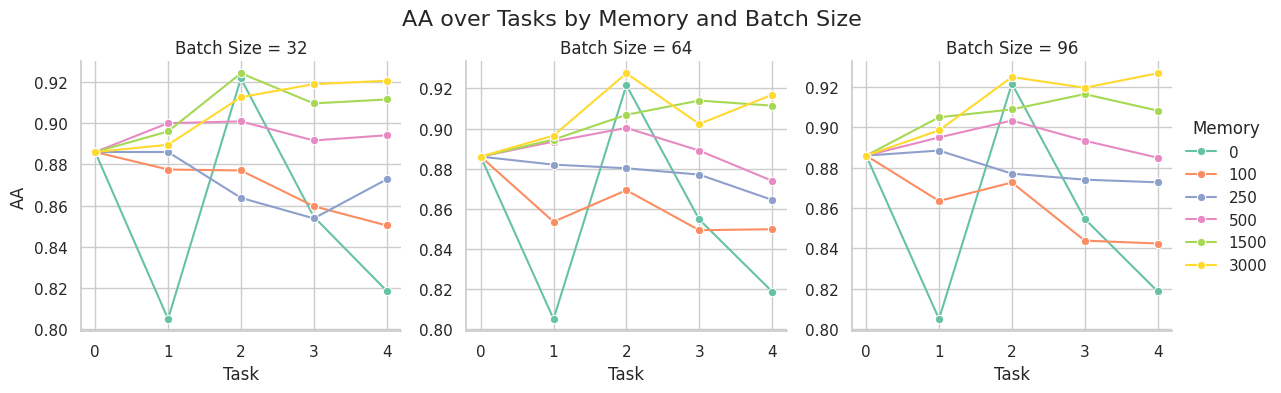

<Figure size 1200x500 with 0 Axes>

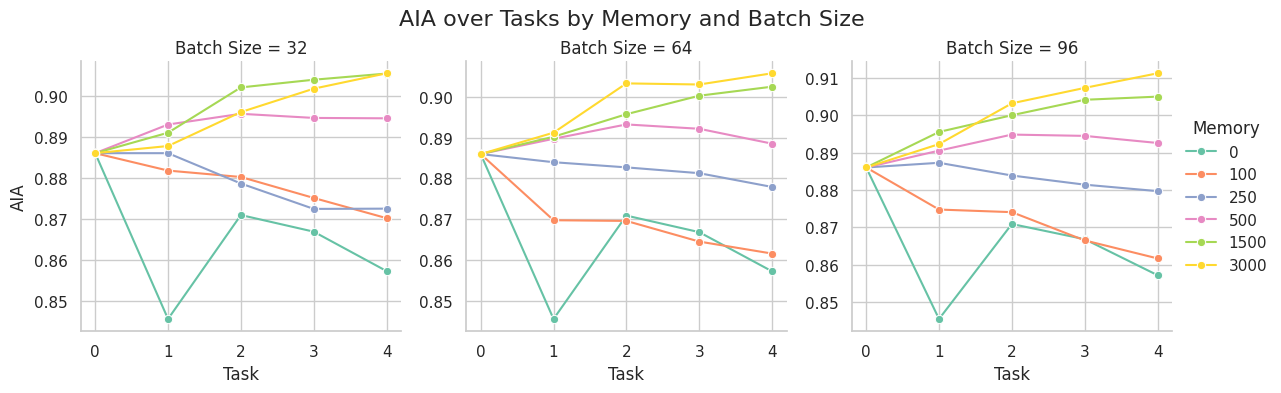

<Figure size 1200x500 with 0 Axes>

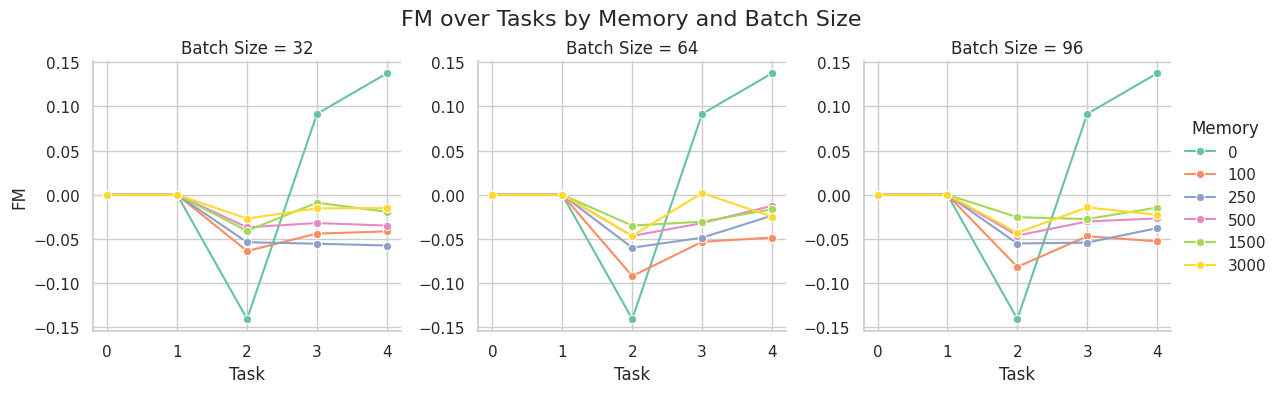

<Figure size 1200x500 with 0 Axes>

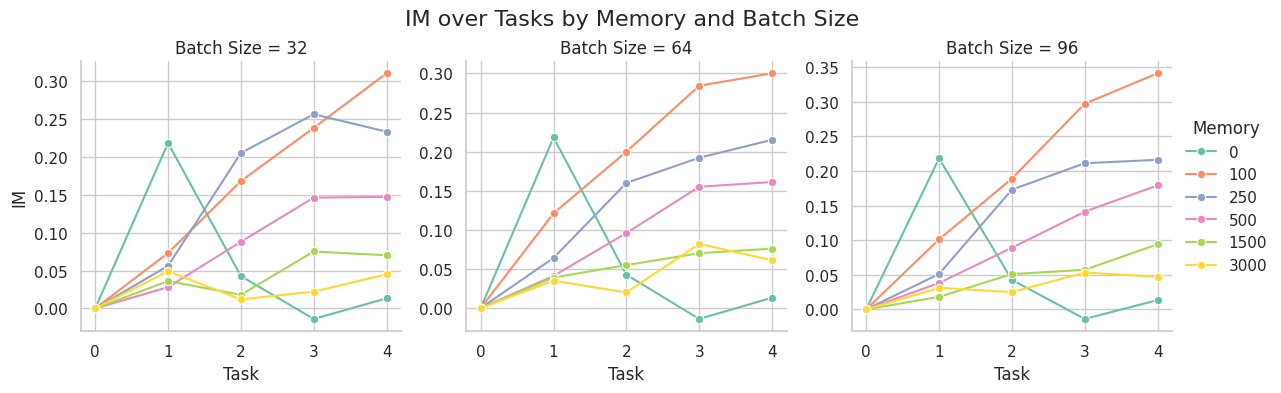

<Figure size 1200x500 with 0 Axes>

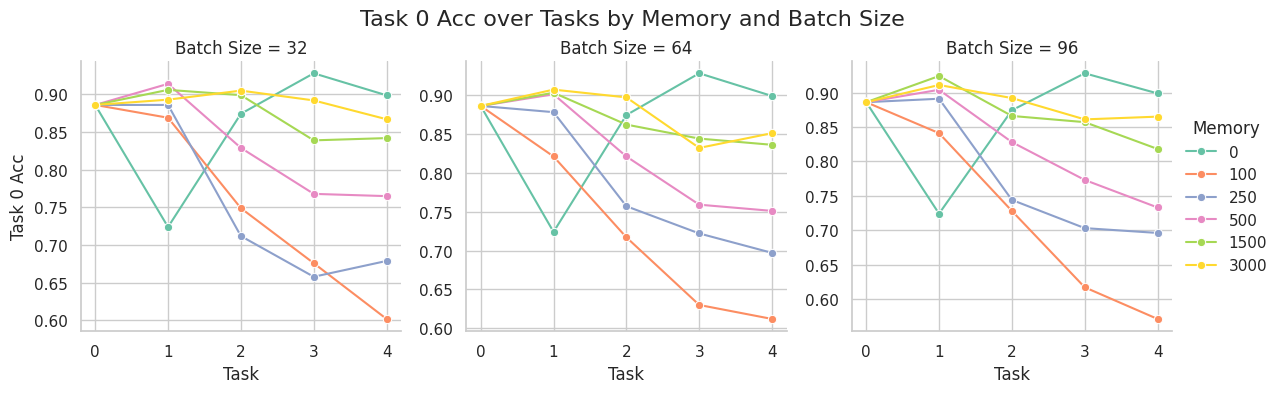

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
indicators = ['AA', 'AIA', 'FM', 'IM', 'Task 0 Acc']

for metric in indicators:
    plt.figure(figsize=(12, 5))
    g = sns.FacetGrid(metrics_df, col="bs", hue="mem", col_wrap=3, height=4, sharey=False, palette="Set2")
    g.map(sns.lineplot, "Task", metric, marker="o")
    g.add_legend(title="Memory")
    g.set_titles("Batch Size = {col_name}")
    g.set_axis_labels("Task", metric)
    g.set(xticks=range(num_tasks))
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{metric} over Tasks by Memory and Batch Size", fontsize=16)
    plt.show()
